In [127]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyssam
from copy import copy

import utils
import alignment

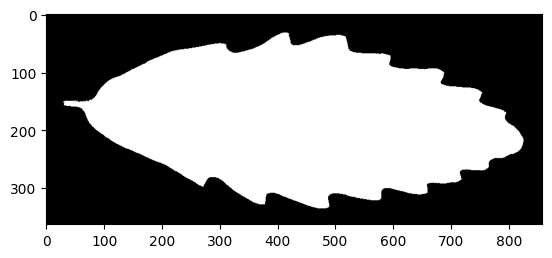

In [93]:
data_path = os.path.join(os.getcwd(), 'data/leaf_dataset/images/')
data_raw = []
for file in sorted(os.listdir(data_path)):
    if file.endswith('.jpg'):
        data_raw.append(plt.imread(data_path + file))

plt.imshow(data_raw[0], cmap = 'gray')
plt.show()

In [29]:
data = []
for shape in data_raw:
    line = plt.contour(shape, levels=[1]).collections[0].get_paths()[0].vertices
    data.append(line)
plt.close()

/tmp/ipykernel_3366311/1519151802.py:3: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  line = plt.contour(shape, levels=[1]).collections[0].get_paths()[0].vertices


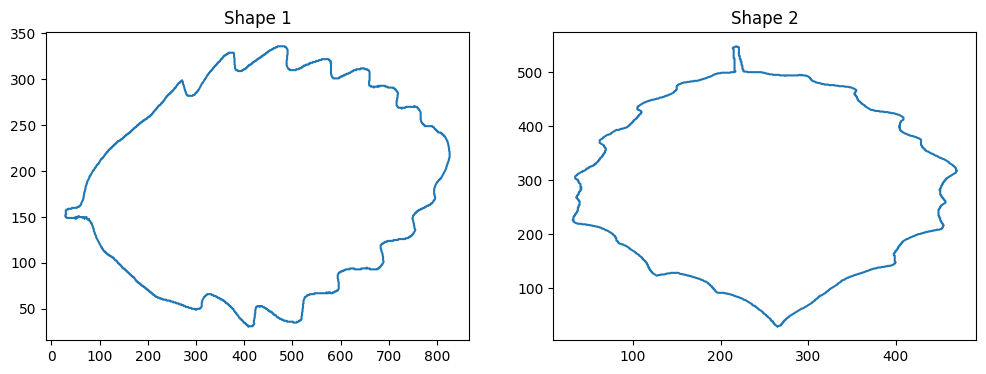

In [78]:
shape_to_plot = 3

fig, ax = plt.subplots(1,2 , figsize = (12,4))
ax[0].plot(data[0][:,0] , data[0][:,1])
ax[1].plot(data[shape_to_plot][:,0] , data[shape_to_plot][:,1])

ax[0].set_title('Shape 1');
ax[1].set_title('Shape 2');

### Interpolation

Before we align the shapes and create a shape model, we need to check if all shapes have the same amount of data points.

In [34]:
lengths = []
for curve in data:
    lengths.append(curve.shape[0])
# Run over all shapes and print True if all curves have the same length, otherwise False
base = lengths[0]
check = True
for item in lengths:
    if item != base:
        check = False
        break
print(check)



False


As our shapes are of different lengths, we first use the interpolate function, which transforms every shape to a chosen number of sampling points. The function also makes sure there are no duplicate points in the shape after the interpolation.

In [35]:
nb_points = 500
data_interp = utils.apply_func_to_list(
    input_list=data, func=lambda x: utils.interpolate(x, nb_points)
)

lengths = []
for curve in data_interp:
    lengths.append(curve.shape[0])
# Run over all shapes and print True if all curves have the same length, otherwise False
base = lengths[0]
check = True
for item in lengths:
    if item != base:
        check = False
        break
print(check)

True


### Alignment

#### Procrustes alignment

The first alignment method we use is the Procrustes analysis alignment. The standard procrustes analysis uses a shape as a reference shape (usually the first shape in the dataset).<br>
It takes every shape in the dataset and first performs standardization (mean 0 and standard deviation 1) and centering around the origin. Then, the shape is transformed (scaled and rotated) to best fit the reference shape, meaning to minimize the sum of squares of the pointwise differences.

In [36]:
data_procustes = utils.apply_func_to_list(
    input_list=data_interp, func=lambda x: alignment.procrustes(shape = x, ref_shape= data_interp[0])
)


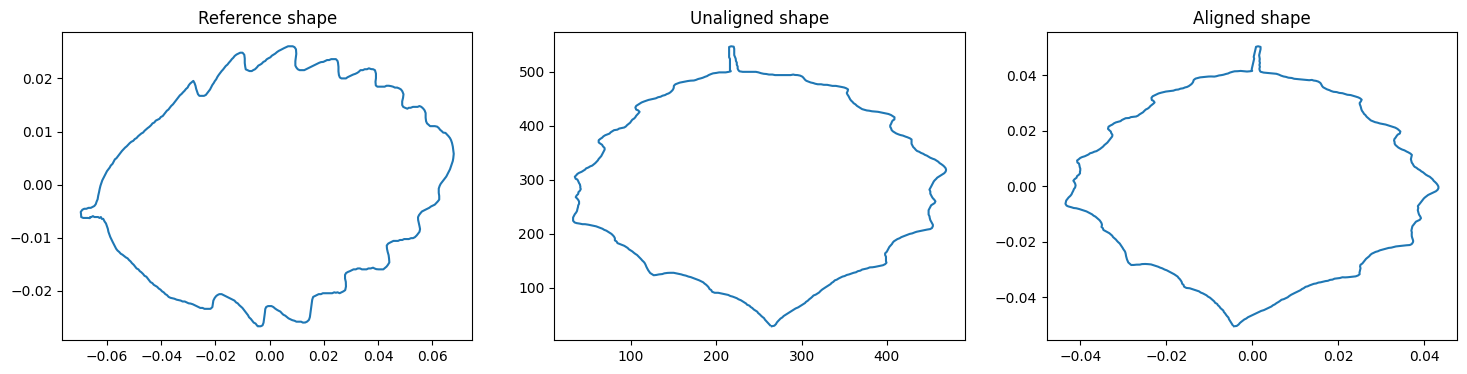

In [79]:
fig, ax = plt.subplots(1,3 , figsize = (18,4))
ax[0].plot(data_procustes[0][:,0] , data_procustes[0][:,1])
ax[1].plot(data_interp[shape_to_plot][:,0] , data_interp[shape_to_plot][:,1])
ax[2].plot(data_procustes[shape_to_plot][:,0] , data_procustes[shape_to_plot][:,1])

ax[0].set_title('Reference shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')

plt.show()

As we can see, the alignment is far from being satisfactory. This is probably due to the fact that our shapes don't have correspondence. In order to deal with this problem, we  perform a correspondence search. The idea is to find the point correspondence that minimizes the pointwise distance out of all alignment attemps. We iteratively pick a point as a starting point, align the shape to the reference shape and move on to try the next point as the starting point. The point that produces the best alignment (smallest pointwise distance) is our best correspondence point.

In [66]:
data_cor_procustes = utils.apply_func_to_list(
    input_list=data_interp, func=lambda x: alignment.correspondence_search(shape = x, ref_shape= data_interp[0])
)

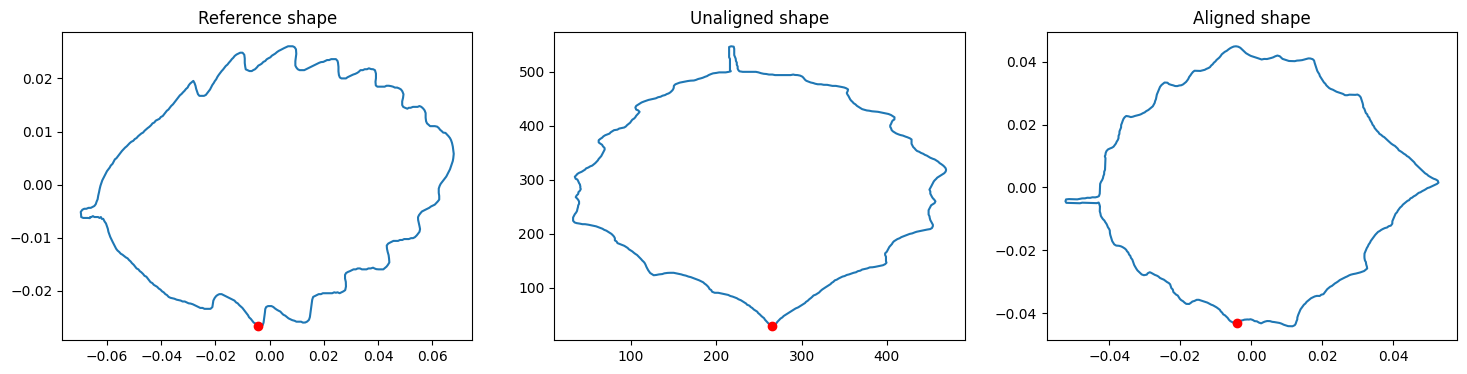

In [80]:
fig, ax = plt.subplots(1,3 , figsize = (18,4))
ax[0].plot(data_cor_procustes[0][:,0] , data_cor_procustes[0][:,1])
ax[1].plot(data_interp[shape_to_plot][:,0] , data_interp[shape_to_plot][:,1])
ax[2].plot(data_cor_procustes[shape_to_plot][:,0] , data_cor_procustes[shape_to_plot][:,1])

ax[0].plot(data_cor_procustes[0][0,0] , data_cor_procustes[0][0,1], "ro")
ax[1].plot(data_interp[shape_to_plot][0,0] , data_interp[shape_to_plot][0,1], "ro")
ax[2].plot(data_cor_procustes[shape_to_plot][0,0] , data_cor_procustes[shape_to_plot][0,1], "ro")

ax[0].set_title('Reference shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')



plt.show()

In the plot above, the same unaligned and aligned shape as above are shown. The red dot shows the start point of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve. The starting point (in red) of the aligned curve was also modified to align with the reference.
Clearly, results look much better now as the aligned shape seems to be rotated to better fit the reference shape.



#### Generalized Procrustes alignment

Our next alignment method is the generalized Procrustes. It is quite similar to the standard Procrustes alignment but rather more robust.
As opposed to aligning all shapes to a reference shape as done in the standard Procrustes, the generalized algorithm works as following:
1. Choose one shape as an initial estimate of the mean shape.
2. Align all shapes to the mean shape
3. Re-estimate the mean from aligned shapes.
4. Align the new mean shape to the old mean shape
5. If not converged, return to step 2.
** Convergence is achieved when the L2 distance between the new and old mean shapes is below a pre-determined tolerance.


In [50]:
# Note that the generalized procrustes alignment function takes the whole data as input, not just one shape and a reference shape like the other functions.
# Therefore, we don't need to apply the apply_func_to_list function to the data as we did before.
data_gen_procrustes, mean_shape =  alignment.generalized_procrustes(data_interp , corr_search = True , tol = 1e-1)

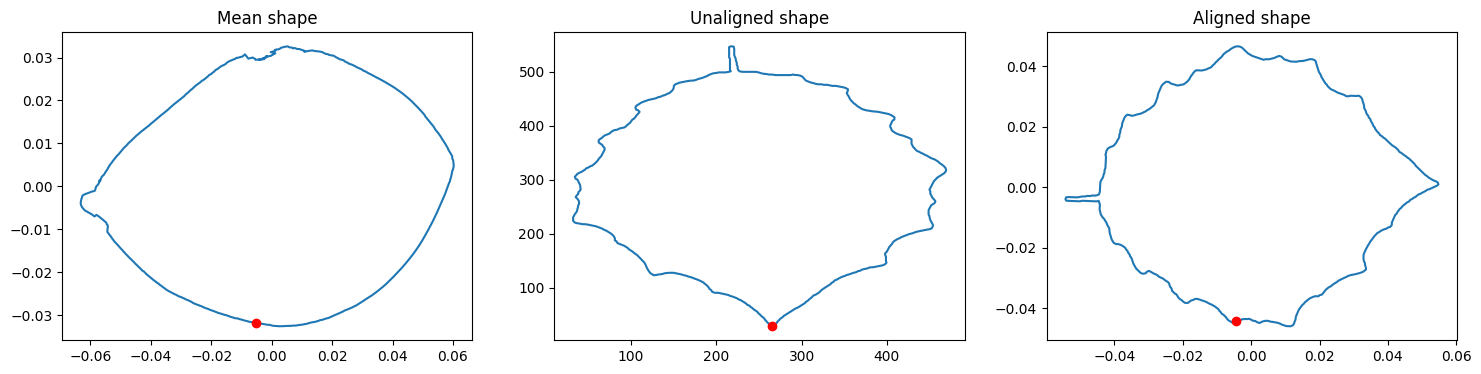

In [81]:
fig, ax = plt.subplots(1,3 , figsize = (18,4))
ax[0].plot(mean_shape[:,0] , mean_shape[:,1])
ax[1].plot(data_interp[shape_to_plot][:,0] , data_interp[shape_to_plot][:,1])
ax[2].plot(data_gen_procrustes[shape_to_plot][:,0] , data_gen_procrustes[shape_to_plot][:,1])

ax[0].plot(mean_shape[0,0] , mean_shape[0,1], "ro")
ax[1].plot(data_interp[shape_to_plot][0,0] , data_interp[shape_to_plot][0,1], "ro")
ax[2].plot(data_gen_procrustes[shape_to_plot][0,0] , data_gen_procrustes[shape_to_plot][0,1], "ro")

ax[0].set_title('Mean shape')
ax[1].set_title('Unaligned shape')
ax[2].set_title('Aligned shape')



plt.show()

In the plot above, we can inspect the differences between using the generalized and standard Procrustes alignment (with our extra correspondence search). <br>
Visibly enough, the alignment of the shape (right curve) seems to not change much. We can see though that the final reference shape (left curve) is significantly different than before.<br>
This is due to the iterative mean shape assessment for the alignment of the shapes, which makes this alignment technique more robust.

### Shape Model

Next, we create a statistical shape model using the Pyssam library. <br>
This library has quick and easy implementations of various shape-model's elements such as PCA analysis and new instance creation based on modification of a selected mode's weights.
The library does not have an implementation of a full alignment process (it only performs centering around the origin and standardization of the data). For that reason, we use the aligned data which was created above.

In [110]:
#Turn the data into a numpy array to fit the Pyssam library
array_gen_procrustes = np.array(data_gen_procrustes).reshape(-1,len(data_gen_procrustes[0]),2)
shape_model = pyssam.SSM(array_gen_procrustes)

#### Mean Shape

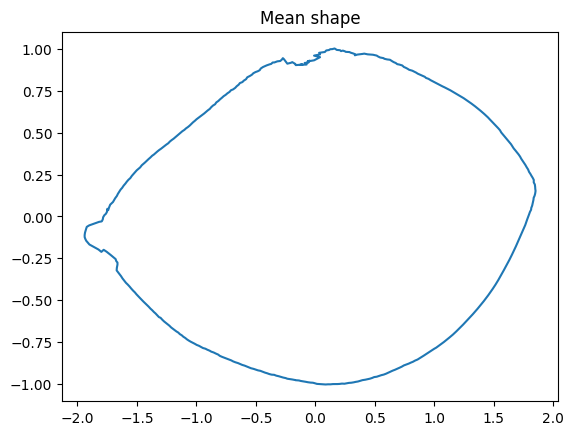

In [123]:
mean_shape_columnvector = shape_model.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 2)

plt.plot(mean_shape[:,0], mean_shape[:,1])
plt.title('Mean shape')
plt.show()

#### PCA Analysis

In [124]:
shape_model.create_pca_model(shape_model.landmarks_columns_scale)
shape_model_componenets = shape_model.pca_model_components

To obtain 90.0% variance, 58 modes are required


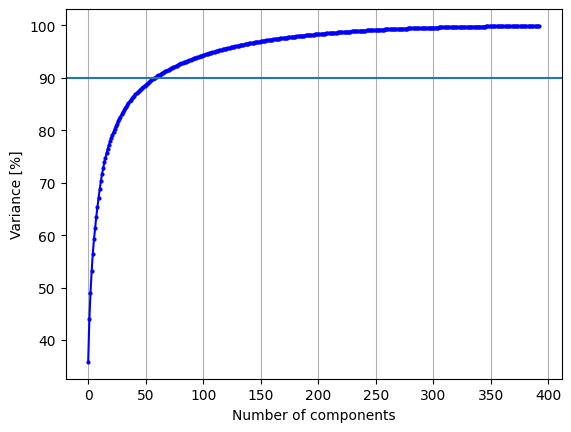

In [126]:
def plot_cumulative_variance(explained_variance, target_variance=0.9):
    top_threshold = np.where(np.cumsum(shape_model.pca_object.explained_variance_ratio_) > 0.999)[0][0]
    number_of_components = np.arange(0, top_threshold +1 )
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance[0:top_threshold+1]*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)

    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()

print(f"To obtain {shape_model.desired_variance*100}% variance, {shape_model.required_mode_number} modes are required")
plot_cumulative_variance(np.cumsum(shape_model.pca_object.explained_variance_ratio_), 0.9)

Next we visualise the first 3 prinipal components, inspecting how they change the mean shape.

In [138]:
def plot_shape_modes(
  mean_shape_columnvector,
  mean_shape,
  original_shape_parameter_vector,
  shape_model_components,
  mode_to_plot,
):
  weights = [-3, 0, 3]
  fig, ax = plt.subplots(1, 3 , figsize = (18,4))
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = shape_model.morph_model(
        mean_shape_columnvector,
        shape_model_components,
        shape_parameter_vector
    ).reshape(-1, 2)


    if weights_i == 0:
      ax[j].plot(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].plot(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")

    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()


explained variance is 35.82%


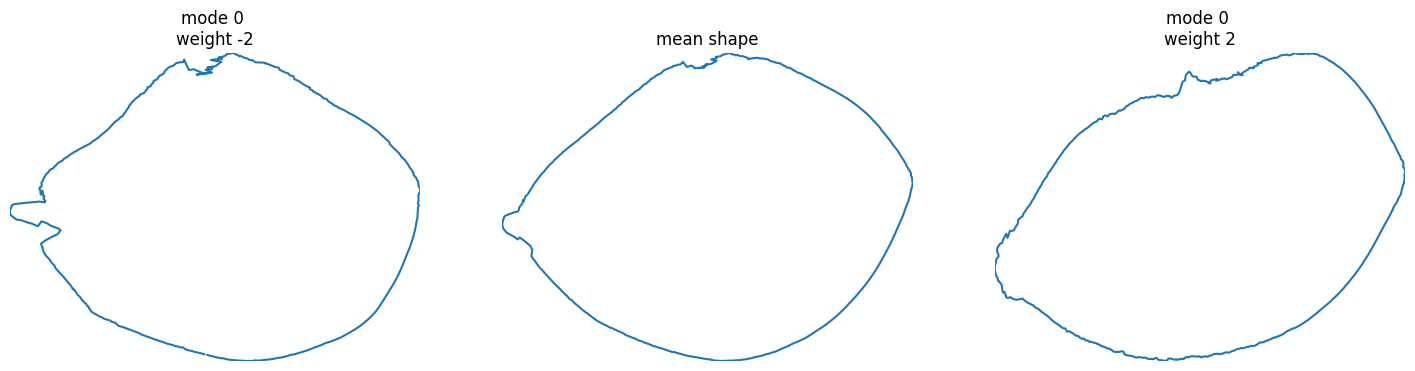

In [137]:
mode_to_plot = 0
print(f"explained variance is {np.round(shape_model.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    shape_model.model_parameters,
    shape_model.pca_model_components,
    mode_to_plot,
)

explained variance is 8.11%


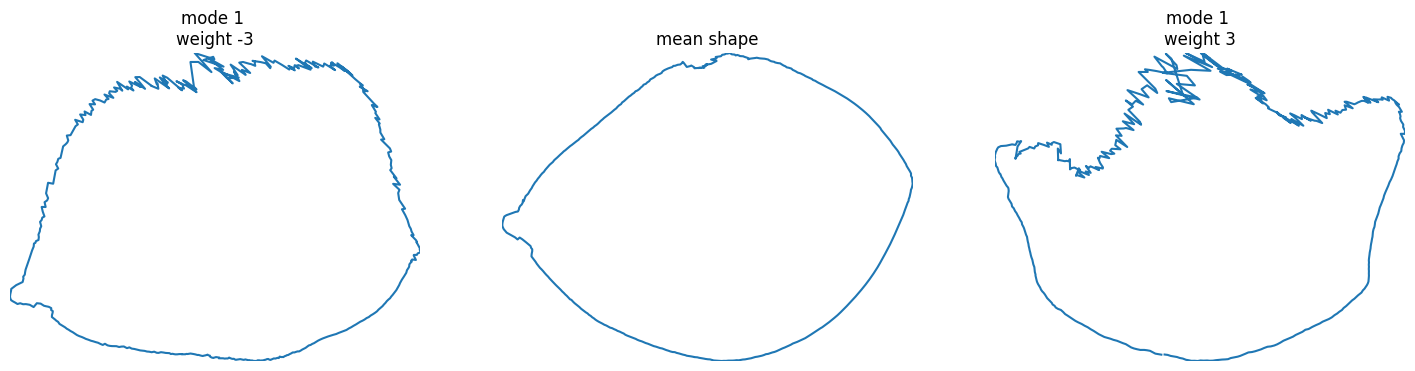

In [134]:
mode_to_plot = 1
print(f"explained variance is {np.round(shape_model.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    shape_model.model_parameters,
    shape_model.pca_model_components,
    mode_to_plot,
)

explained variance is 5.04%


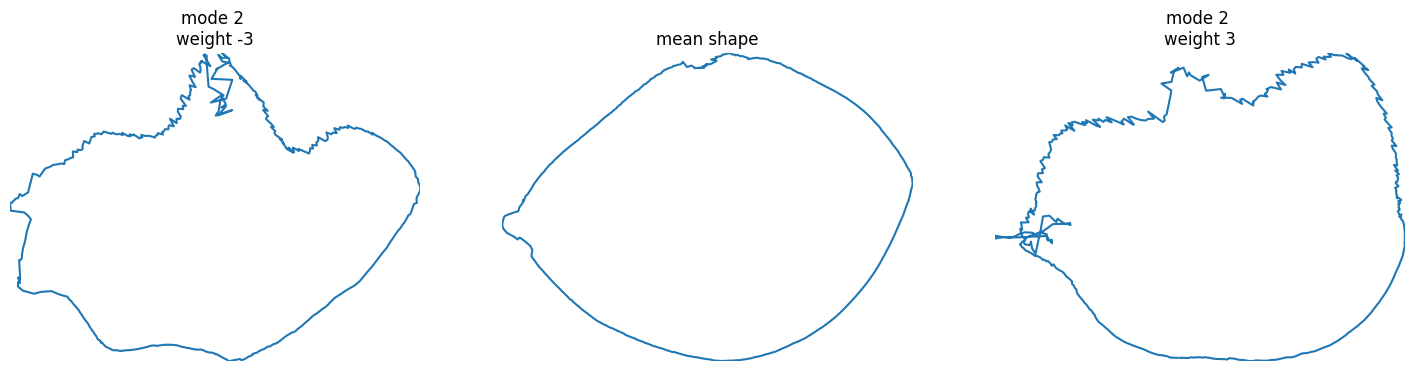

In [135]:
mode_to_plot = 2
print(f"explained variance is {np.round(shape_model.pca_object.explained_variance_ratio_[mode_to_plot]*100,2)}%")

plot_shape_modes(
    mean_shape_columnvector,
    mean_shape,
    shape_model.model_parameters,
    shape_model.pca_model_components,
    mode_to_plot,
)